# Integrate People with Theme 1
Demo to show how to join people (housing unit allocation point data) with Theme 1 - Air, Water, and Climate data.

Examples will include:
1. Geotiff
2. NetCDF
3. Shapefile

## Description of Program
- program:    aqe_2av1_CKANjoin_2025-10-30
- task:       Read files from CKAN - Join HUA with File
- Version:    2025-10-30
- project:    Southeast Texas Urban Integrated Field Lab
- funding:	  DOE
- author:     Nathanael Rosenheim

## Step 0: Good Housekeeping

In [36]:
# 1. Import all packages
import pandas as pd     # For obtaining and cleaning tabular data
import geopandas as gpd # For obtaining and cleaning spatial data
import matplotlib.pyplot as plt # For plotting
import contextily as ctx # For adding basemaps
import os # For saving output to path
import zipfile # For handling zip files
import io # For handling in-memory data
import requests # For downloading data
import rasterio # For reading geotiff files

In [2]:
# 2. Check versions
import sys
print("Python Version     ", sys.version)
print("geopandas version: ", gpd.__version__)

Python Version      3.13.9 | packaged by conda-forge | (main, Oct 22 2025, 23:12:41) [MSC v.1944 64 bit (AMD64)]
geopandas version:  1.1.1


In [3]:
# 3. Check working directory
# Get information on current working directory (getcwd)
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\GitHub\\integrate_people_theme1_cookbook'

In [4]:
#4. Store Program Name for output files to have the same name
programname = "aqe_2av1_CKANjoin_2025-10-30"
# Make directory to save output
#if not os.path.exists(programname):
#    os.mkdir(programname)

In [5]:
# Functions to explore the housing unit allocation results
# load functions from Github repository
ncoda_00d_cleanvarsutils_url = "https://github.com/npr99/intersect-community-data/raw/main/pyncoda/ncoda_00d_cleanvarsutils.py"
ncoda_04c_poptableresults_url = "https://github.com/npr99/intersect-community-data/raw/main/pyncoda/ncoda_04c_poptableresults.py"

import requests
import importlib.util

# Load the clean vars utils functions
response1 = requests.get(ncoda_00d_cleanvarsutils_url)
exec(response1.text)

# Load the pop table results functions - skip first 5 lines
response2 = requests.get(ncoda_04c_poptableresults_url)
# Split into lines, skip first 5, then rejoin
lines = response2.text.split('\n')
code_to_exec = '\n'.join(lines[5:])
exec(code_to_exec)

print("Successfully loaded functions from both GitHub repositories")

Successfully loaded functions from both GitHub repositories


# Step 1: Obtain Data
Obtain publicly available data on CKAN

https://ckan.tacc.utexas.edu/organization/setx-uifl

- Housing unit level population data allocated to structures
- Study site boundaries
- Social Vulnerability Data
- Digital Elevation Maps
- Air pollution

In [32]:
# housing unit allocation data from CKAN
data_title = "2020 Housing Unit Allocation for SETX"
url = "https://ckan.tacc.utexas.edu/dataset/62308724-7eac-45ed-aeab-d4d6a46128e1/resource/5154eb5e-d8ff-4183-b361-fd530513e3c1/download/hua_v2-0-0_setxuifl_tx_nsi_2020_nsi_rs9876.csv"

# read in blockid, bgid, tractid, FIPSCounty as strings
dtypes_dict = {
    'blockid': str,
    'bgid': str,
    'tractid': str,
    'FIPSCounty': str
}
hua_df = pd.read_csv(url, dtype=dtypes_dict)
hua_df.head(1)

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid_Block2020_flagsetrm,addrptid,fd_id_bid,huestimate,huicounter_addpt,placeNAME20,x,y,occtype,geometry
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,2.0,ST00nsi-481325235-86274HQQ+WH4-8-3-8-4AP000000,nsi-481325235-86274HQQ+WH4-8-3-8-4,0.0,1.0,Sour Lake,-94.411062,30.139761,COM1,POINT (-94.411062 30.139761)


In [7]:
# task force sites
data_title = "Task Force Top Two Focus Sites"
url = "https://ckan.tacc.utexas.edu/dataset/cfe91d1b-3aa9-4de1-ba76-2837deb87649/resource/7e2e3d0e-60cc-4fb1-beea-d30a62cdd1e9/download/task_force_sites_top_focus_may_2024.zip"

tfsites_gdf = gpd.read_file(url)
tfsites_gdf.head()

,Shape_Leng,Shape_Area,Site_Name,geometry
0,0.0,0.0,West Port Arthur - Foley Watershed,"POLYGON Z ((-10458830.588 3488032.728 0, -1045..."
1,0.0,0.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...,"POLYGON Z ((-10476419.371 3513315.472 0, -1047..."


In [30]:
# Add SVI data by tract and block group
data_title = "2020 SVI Data for SETX Block Groups"
blockgroup_svi_url = 'https://ckan.tacc.utexas.edu/dataset/aba7c155-b112-45a5-8a6f-d826cda08c8f/resource/8c77ff75-e8dc-436c-af09-d353b7adea0c/download/tu3svi4_2av2_svioptions_2025-04-16_bg2020_setx.zip'
blockgroup_svi_gdf = gpd.read_file(blockgroup_svi_url)
blockgroup_svi_gdf.head(1)

,BG2020,ALAND,AWATER,U202020010,U202020013,U202020020,U202020031,U202020033,U202020040,U202020070,...,H202090093,H202091012,H202091093,H202092021,SETX,FIPSCNTY,TRACT2020,airsite_bg,airsite_na,geometry
0,482450108004,1805083,0,0.11097,0.33012,0.0,-24429.0,-0.03282,-185900.0,1033.0,...,0.323,1.0,1.0,1.0,1.0,48245,48245010800,0.0,None,"POLYGON ((-93.96848 29.98396, -93.96712 29.985..."


In [31]:
data_title = "2020 SVI Data for SETX Tracts"
tract_svi_url = 'https://ckan.tacc.utexas.edu/dataset/aba7c155-b112-45a5-8a6f-d826cda08c8f/resource/112f6e55-f843-46bc-bd2f-952753efbab2/download/tu3svi4_2av2_svioptions_2025-04-16_tract2020_setx.zip'
tract_svi_gdf = gpd.read_file(tract_svi_url)
tract_svi_gdf.head(1)

,TRACT2020,ALAND,AWATER,U202020010,U202020013,U202020020,U202020031,U202020033,U202020040,U202020070,...,H202090093,H202091012,H202091093,H202092021,SETX,FIPSCNTY,airsite_tr,airsite_na,area_m^2,geometry
0,48351950100,779155722,9905672,0.31786,0.43767,0.13483,-23537.0,-0.00928,-77100.0,827.0,...,0.594,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.91113 31.15807, -93.90629 31.158..."


In [34]:
data_title = "2020 SVI Data Dictionary"
svi_datadictionary_url = 'https://ckan.tacc.utexas.edu/dataset/aba7c155-b112-45a5-8a6f-d826cda08c8f/resource/c25d8010-a142-4ee8-8eea-fe7fa3ca4b4d/download/tu3svi4_2av2_svioptions_2025-04-16_all_vars_datadictionary.csv.xlsx'
# read in xlsx file
svi_datadictionary_df = pd.read_excel(svi_datadictionary_url)
svi_datadictionary_df.head(1)


,SVI,year,newvarname,SVIcat,label,oldvarname
0,CDC,2020,C202010010,Geocode,Census Tract 11 Digit Geocode,FIPS


In [ ]:
# Add DEM data

In [37]:
# Add Air Pollution Data
air_pollution_url = "https://ckan.tacc.utexas.edu/dataset/c3c1b2b2-4d43-4603-b1c5-fc0877c279ae/resource/465209c8-f407-4eb2-99b3-4fc719e168c3/download/benz_ppb_pxxx.zip"

# Dictionary to store the geotiff data
air_pollution_dict = {}

# Download and read TIFF files from the zip
response = requests.get(air_pollution_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Get list of all files in the zip
    file_list = z.namelist()
    
    # Filter for .tif files
    tif_files = [f for f in file_list if f.endswith('.tif') or f.endswith('.tiff')]
    
    print(f"Found {len(tif_files)} TIFF files:")
    for tif_file in tif_files:
        print(f"  - {tif_file}")
    
    # Read each TIFF file into the dictionary
    for tif_file in tif_files:
        # Extract the filename without extension for the dictionary key
        filename = os.path.splitext(os.path.basename(tif_file))[0]
        
        # Read the TIFF file data
        with z.open(tif_file) as file_data:
            # Use rasterio to read the geotiff
            with rasterio.open(file_data) as src:
                # Store the rasterio dataset in the dictionary
                air_pollution_dict[filename] = {
                    'data': src.read(),  # Read all bands
                    'transform': src.transform,
                    'crs': src.crs,
                    'meta': src.meta,
                    'bounds': src.bounds,
                    'width': src.width,
                    'height': src.height
                }
        
        print(f"Loaded {filename} - Shape: {air_pollution_dict[filename]['data'].shape}, CRS: {air_pollution_dict[filename]['crs']}")

print(f"\nSuccessfully loaded {len(air_pollution_dict)} geotiff files into dictionary")
print(f"Dictionary keys: {list(air_pollution_dict.keys())}")

Found 5 TIFF files:
  - benz_ppb_p100.tif
  - benz_ppb_p50.tif
  - benz_ppb_p75.tif
  - benz_ppb_p90.tif
  - benz_ppb_p95.tif
Loaded benz_ppb_p100 - Shape: (1, 72, 72), CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["false_easting",-252000],PARAMETER["false_northing",1152000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Loaded benz_ppb_p50 - Shape: (1, 72, 72), CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PA

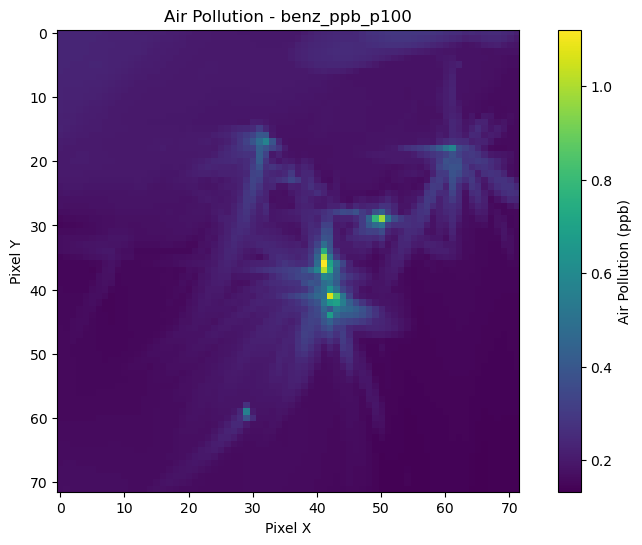

In [38]:
# check one of the geotiff files
sample_key = list(air_pollution_dict.keys())[0]
sample_data = air_pollution_dict[sample_key]['data']

# Visualize the sample data
plt.figure(figsize=(10, 6))
plt.imshow(sample_data[0], cmap='viridis')
plt.colorbar(label='Air Pollution (ppb)')
plt.title(f"Air Pollution - {sample_key}")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

# Step 2: Clean Data

In [39]:
# convert hua_df to a GeoDataFrame
# use geometry column
hua_gdf = gpd.GeoDataFrame(hua_df, geometry=gpd.GeoSeries.from_wkt(hua_df['geometry']), crs="EPSG:4326")
hua_gdf.head()

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid_Block2020_flagsetrm,addrptid,fd_id_bid,huestimate,huicounter_addpt,placeNAME20,x,y,occtype,geometry
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,2.0,ST00nsi-481325235-86274HQQ+WH4-8-3-8-4AP000000,nsi-481325235-86274HQQ+WH4-8-3-8-4,0.0,1.0,Sour Lake,-94.411062,30.139761,COM1,POINT (-94.41106 30.13976)
1,B481990302002008H001,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,2.0,ST00nsi-481325996-86274HQQ+XP2-3-2-3-1AP000000,nsi-481325996-86274HQQ+XP2-3-2-3-1,0.0,1.0,Sour Lake,-94.410730,30.139890,COM4,POINT (-94.41073 30.13989)
2,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nsi-481326655-86274HQQ+JQ2-3-2-4-2,NaN,NaN,NaN,NaN,NaN,RES1-1SNB,POINT (-94.4106 30.139)
3,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nsi-481326679-86274HQQ+JPC-3-2-3-2,NaN,NaN,NaN,NaN,NaN,RES1-1SNB,POINT (-94.41073 30.13906)
4,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nsi-481326680-86274HRV+25G-4-3-1-2,NaN,NaN,NaN,NaN,NaN,COM4,POINT (-94.40704 30.14007)


<Axes: >

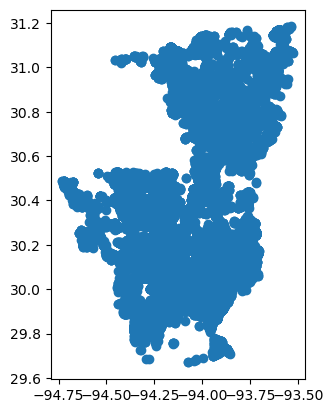

In [40]:
hua_gdf.plot()

<Axes: >

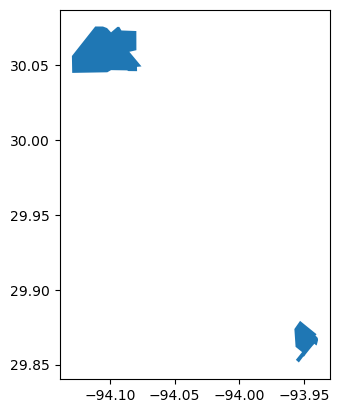

In [42]:
# convert task force site CRS to match hua_gdf
tfsites_gdf = tfsites_gdf.to_crs(hua_gdf.crs)
tfsites_gdf.plot()

In [43]:
# add site id to task force gdf
tfsites_gdf['Site_ID'] = tfsites_gdf.index + 1
tfsites_gdf = tfsites_gdf[['Site_ID','Site_Name', 'geometry']]
tfsites_gdf.head()

,Site_ID,Site_Name,geometry
0,1,West Port Arthur - Foley Watershed,"POLYGON Z ((-93.95327 29.87921 0, -93.94959 29..."
1,2,Southeast Beaumont - Hillebrant Bayou/Tenmile ...,"POLYGON Z ((-94.11128 30.07594 0, -94.10533 30..."


### Spatial Join
Add Task Force Site ID to HUA

In [44]:
# spatial join hua_gdf with tfsites_gdf
hua_tfsites_gdf = gpd.sjoin(hua_gdf, tfsites_gdf, how="left", predicate="intersects")
hua_tfsites_gdf.head()

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,huestimate,huicounter_addpt,placeNAME20,x,y,occtype,geometry,index_right,Site_ID,Site_Name
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,0.0,1.0,Sour Lake,-94.411062,30.139761,COM1,POINT (-94.41106 30.13976),NaN,NaN,NaN
1,B481990302002008H001,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,0.0,1.0,Sour Lake,-94.410730,30.139890,COM4,POINT (-94.41073 30.13989),NaN,NaN,NaN
2,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,RES1-1SNB,POINT (-94.4106 30.139),NaN,NaN,NaN
3,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,RES1-1SNB,POINT (-94.41073 30.13906),NaN,NaN,NaN
4,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,COM4,POINT (-94.40704 30.14007),NaN,NaN,NaN


In [49]:
#  select census tracts that intersect with task force sites
hua_tfsites_gdf_tracts = hua_tfsites_gdf[~hua_tfsites_gdf['Site_ID'].isna()]
# summarize number of tracts intersecting with each site
hua_tfsites_gdf_tracts.groupby(['Site_ID','tractid']).size()


Site_ID  tractid    
1.0      48245005100     427
         48245005900     582
2.0      48245001200      73
         48245001700     748
         48245001900    1034
         48245002000     873
         48245002100    1034
         48245002200     583
         48245002300     913
         48245002400    1083
         48245002500     291
         48245002600     581
         48245011700     158
dtype: int64

In [51]:
# how many unique tracts intersect with task force sites
# count by Site_ID
hua_tfsites_gdf_tracts.groupby('Site_ID')['tractid'].nunique()

Site_ID
1.0     2
2.0    11
Name: tractid, dtype: int64

In [52]:
#  select census tracts that intersect with task force sites
hua_tfsites_gdf_bg = hua_tfsites_gdf[~hua_tfsites_gdf['Site_ID'].isna()]
# summarize number of tracts intersecting with each site
hua_tfsites_gdf_bg.groupby(['Site_ID','bgid']).size()

Site_ID  bgid        
1.0      482450051001    213
         482450051002    214
         482450059001    406
         482450059002    176
2.0      482450012002     73
         482450017001    271
         482450017002    243
         482450017003    234
         482450019001    340
         482450019002    245
         482450019003    449
         482450020001    316
         482450020002    557
         482450021001    123
         482450021002    569
         482450021003    342
         482450022001    213
         482450022002    131
         482450022003    239
         482450023001    322
         482450023002    309
         482450023003    202
         482450023004     80
         482450024001    256
         482450024002    268
         482450024003    268
         482450024004    291
         482450025001    291
         482450026002     45
         482450026004    536
         482450117002    158
dtype: int64

In [53]:
# how many unique tracts intersect with task force sites
# count by Site_ID
hua_tfsites_gdf_bg.groupby('Site_ID')['bgid'].nunique()

Site_ID
1.0     4
2.0    27
Name: bgid, dtype: int64

In [56]:
tract_svi_gdf.head()

,TRACT2020,ALAND,AWATER,U202020010,U202020013,U202020020,U202020031,U202020033,U202020040,U202020070,...,H202090093,H202091012,H202091093,H202092021,SETX,FIPSCNTY,airsite_tr,airsite_na,area_m^2,geometry
0,48351950100,779155722,9905672,0.31786,0.43767,0.13483,-23537.0,-0.00928,-77100.0,827.0,...,0.594,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.91113 31.15807, -93.90629 31.158..."
1,48351950300,485357049,2214858,0.30314,0.51767,0.09422,-20002.0,-0.00000,-67800.0,632.0,...,0.542,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.88919 30.43845, -93.88899 30.441..."
2,48351950400,296202703,605235,0.19510,0.37127,0.06878,-26501.0,-0.04757,-101900.0,821.0,...,0.519,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.90145 30.25293, -93.90145 30.252..."
3,48241950701,344503029,3181130,0.03623,0.37354,0.10871,-35488.0,-0.04386,-113200.0,584.0,...,0.382,2.0,2.0,1.0,1.0,48241,0.0,None,NaN,"POLYGON ((-94.12066 30.28106, -94.12042 30.281..."
4,48241950102,444058152,6807777,0.11693,0.43997,0.06844,-39065.0,-0.08815,-93800.0,1087.0,...,0.450,2.0,2.0,1.0,1.0,48241,0.0,None,NaN,"POLYGON ((-94.46017 31.03122, -94.45981 31.031..."


In [61]:
# make list of unique tracts in site list with sitename
# get unique tract/site combinations
tract_site_df = hua_tfsites_gdf_tracts[['tractid','Site_ID','Site_Name']].drop_duplicates()
# drop Nan Tractids
tract_site_df = tract_site_df.dropna()
tract_site_df

,tractid,Site_ID,Site_Name
36122,48245005900,1.0,West Port Arthur - Foley Watershed
37720,48245002200,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
40816,48245002400,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
42090,48245002100,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45309,48245011700,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45437,48245001900,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
68991,48245005100,1.0,West Port Arthur - Foley Watershed
88417,48245002600,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
88915,48245001700,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
89712,48245002500,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...


In [62]:
# make list of unique bg in site list with sitename
# get unique bg/site combinations
bg_site_df = hua_tfsites_gdf_tracts[['bgid','Site_ID','Site_Name']].drop_duplicates()
# drop Nan Tractids
bg_site_df = bg_site_df.dropna()
bg_site_df

,bgid,Site_ID,Site_Name
36122,482450059001,1.0,West Port Arthur - Foley Watershed
37720,482450022002,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
40816,482450024003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
42090,482450021003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45309,482450117002,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45437,482450019003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
49845,482450021001,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
50060,482450022003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
50810,482450024002,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
50903,482450022001,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...


In [65]:
tract_site_df.head()

,tractid,Site_ID,Site_Name
36122,48245005900,1.0,West Port Arthur - Foley Watershed
37720,48245002200,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
40816,48245002400,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
42090,48245002100,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45309,48245011700,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...


<Axes: >

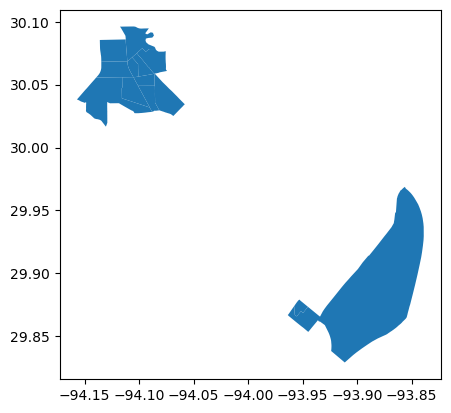

In [72]:
# merge tract_site_df with tract_svi_gdf
tract_site_gdf = tract_svi_gdf.merge(tract_site_df, left_on='TRACT2020', right_on='tractid')
# keep if site id is not null
tract_site_gdf = tract_site_gdf[~tract_site_gdf['Site_ID'].isna()]
tract_site_gdf.plot()

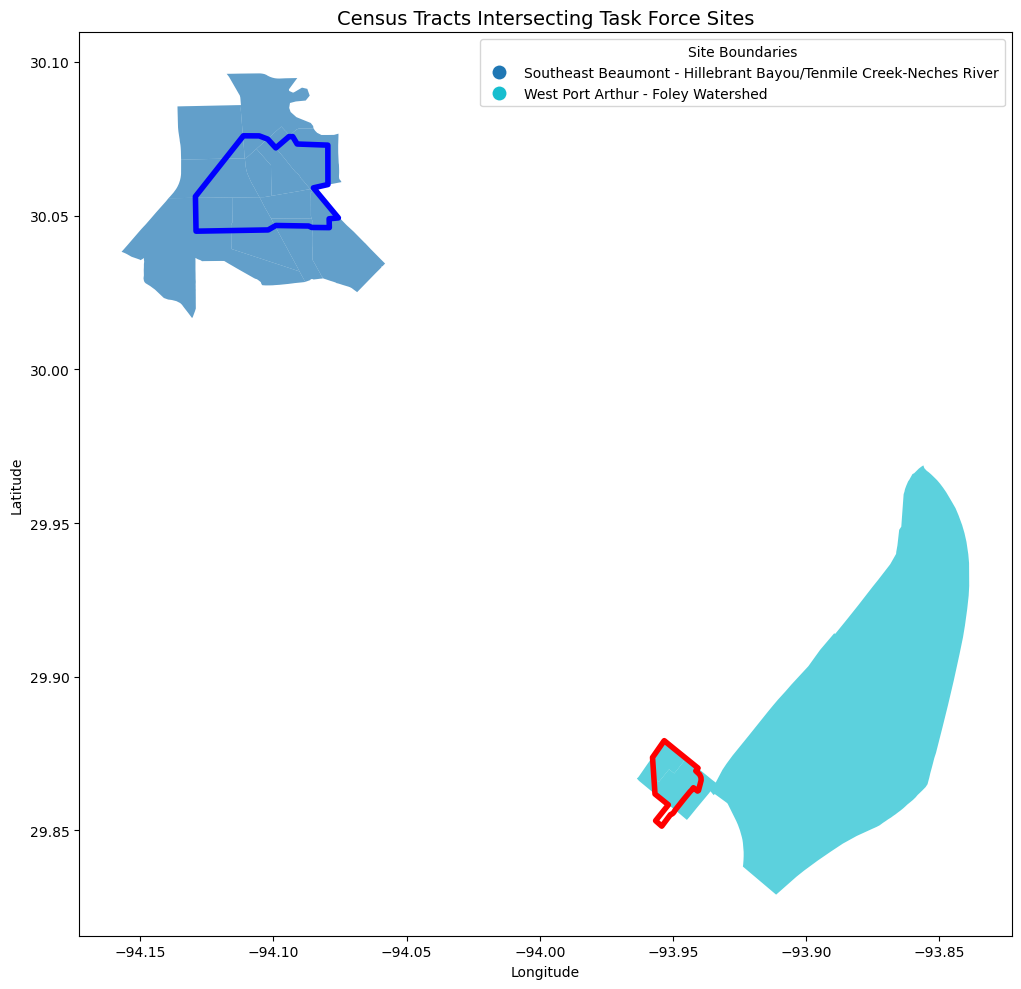

In [76]:
# make a map that shows the task force sites and the intersecting census tracts
fig, ax = plt.subplots(figsize=(12, 10))

# Plot census tracts colored by Site_Name
tract_site_gdf.plot(column='Site_Name', legend=True, ax=ax, alpha=0.7, 
                   legend_kwds={'title': 'Task Force Sites'})

# Plot task force sites as colored outlines based on Site_Name
tfsites_gdf.plot(ax=ax, facecolor='none', column='Site_Name', 
                edgecolor=['red', 'blue'], linewidth=4, legend=True,
                legend_kwds={'title': 'Site Boundaries', 'loc': 'upper right'})

plt.title("Census Tracts Intersecting Task Force Sites", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

# Step 3: Explore Data

In [15]:
# describe results by Site_ID
hua_tfsites_gdf.groupby('Site_ID').size()

Site_ID
1.0    1223
2.0    8443
dtype: int64

<Axes: >

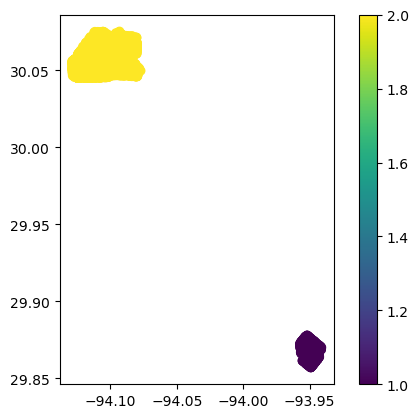

In [16]:
# plot points by Site_ID
hua_tfsites_gdf.plot(column='Site_ID', legend=True)

In [17]:
# Add race ethnicity categories
hua_tfsites_gdf_addrace = PopResultsTable.add_race_ethnicity_to_pop_df(hua_tfsites_gdf)

In [18]:
PopResultsTable.pop_results_table(
                  input_df = hua_tfsites_gdf_addrace, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Southeast Texas',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","190,993 (64.4%)","48,649 (37.8%)","239,642 (56.4%)"
"2 Black alone, Not Hispanic","45,982 (15.5%)","50,382 (39.2%)","96,364 (22.7%)"
"3 American Indian and Alaska Native alone, Not Hispanic",883 (0.3%),435 (0.3%),"1,318 (0.3%)"
"4 Asian alone, Not Hispanic","7,896 (2.7%)","3,199 (2.5%)","11,095 (2.6%)"
"5 Other Race, Not Hispanic","7,800 (2.6%)","3,666 (2.9%)","11,466 (2.7%)"
"6 Any Race, Hispanic","42,897 (14.5%)","22,260 (17.3%)","65,157 (15.3%)"
Total,"296,451 (100.0%)","128,591 (100.0%)","425,042 (100.0%)"


In [19]:
# look just at site 1
site1_hua_gdf = hua_tfsites_gdf_addrace[hua_tfsites_gdf_addrace['Site_ID'] == 1]
PopResultsTable.pop_results_table(
                  input_df = site1_hua_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Site 1 - West Port Arthur',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic",64 (7.2%),47 (4.4%),111 (5.7%)
"2 Black alone, Not Hispanic",678 (76.0%),908 (85.5%),"1,586 (81.2%)"
"3 American Indian and Alaska Native alone, Not Hispanic",1 (0.1%),2 (0.2%),3 (0.2%)
"4 Asian alone, Not Hispanic",14 (1.6%),11 (1.0%),25 (1.3%)
"5 Other Race, Not Hispanic",33 (3.7%),16 (1.5%),49 (2.5%)
"6 Any Race, Hispanic",102 (11.4%),78 (7.3%),180 (9.2%)
Total,892 (100.0%),"1,062 (100.0%)","1,954 (100.0%)"


In [20]:
# look just at site 2
site2_hua_gdf = hua_tfsites_gdf_addrace[hua_tfsites_gdf_addrace['Site_ID'] == 2]
PopResultsTable.pop_results_table(
                  input_df = site2_hua_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Site 2 - Southeast Beaumont',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic",392 (4.4%),515 (7.3%),907 (5.7%)
"2 Black alone, Not Hispanic","5,003 (56.0%)","4,733 (66.7%)","9,736 (60.8%)"
"3 American Indian and Alaska Native alone, Not Hispanic",6 (0.1%),11 (0.2%),17 (0.1%)
"4 Asian alone, Not Hispanic",218 (2.4%),93 (1.3%),311 (1.9%)
"5 Other Race, Not Hispanic",175 (2.0%),155 (2.2%),330 (2.1%)
"6 Any Race, Hispanic","3,135 (35.1%)","1,585 (22.3%)","4,720 (29.5%)"
Total,"8,929 (100.0%)","7,092 (100.0%)","16,021 (100.0%)"


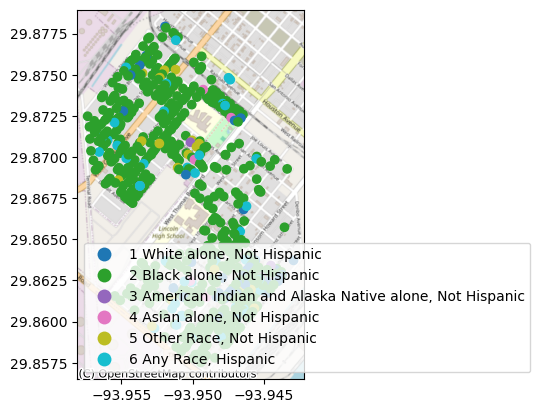

In [21]:
# select points for site ID 1
ax = site1_hua_gdf.plot(column='Race Ethnicity', 
        legend=True)

ctx.add_basemap(ax, crs=site1_hua_gdf.crs, 
        source=ctx.providers.OpenStreetMap.Mapnik)

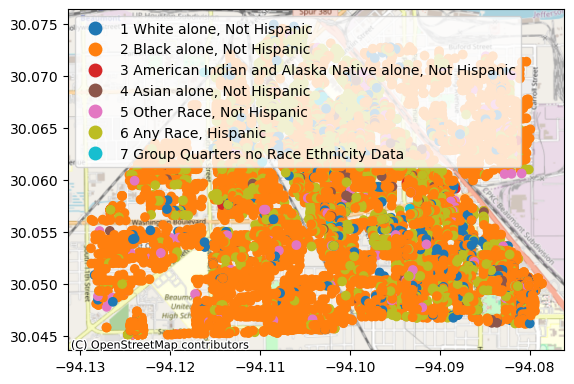

In [22]:
# select points for site ID 2
ax = site2_hua_gdf.plot(column='Race Ethnicity', 
        legend=True)

ctx.add_basemap(ax, crs=site2_hua_gdf.crs, 
        source=ctx.providers.OpenStreetMap.Mapnik)

# Output files

In [23]:
# Save Work at this point as CSV
savefile = programname+"_site1.csv"
site1_hua_gdf.to_csv(savefile, index=False)

In [24]:
# Save Work at this point as CSV
savefile = programname+"_site2.csv"
site2_hua_gdf.to_csv(savefile, index=False)